# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [3]:
vif_data = pd.DataFrame()
vif_data["feature"] = pitch_data.columns

vif_data["VIF"] = [variance_inflation_factor(pitch_data.values, i)
                          for i in range(len(pitch_data.columns))]

vif_data.sort_values(by = 'VIF').head(23)

,feature,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575
30,poor_weak%,2.339208
60,sl_hb,2.433292
64,ch%,2.848569
74,cb_hb,2.861837
56,4seam_velo_range,2.870094


In [4]:
X = pitch_data[['age', 'cu_hb', 'edge%', 
                'solid_contact%', 'poor_weak%', 
                'sl_hb', 'ch%', 'cb_hb', 
                '4seam_velo_range', '4seam%', 
                'cu%', 'cb%', '4seam_vb', 
                'sl_brk', 'sl%', 'sweet_spot%', 
                '4seam_hb', 'hard_hit%', 'ch_hb', 'ev_avg']]

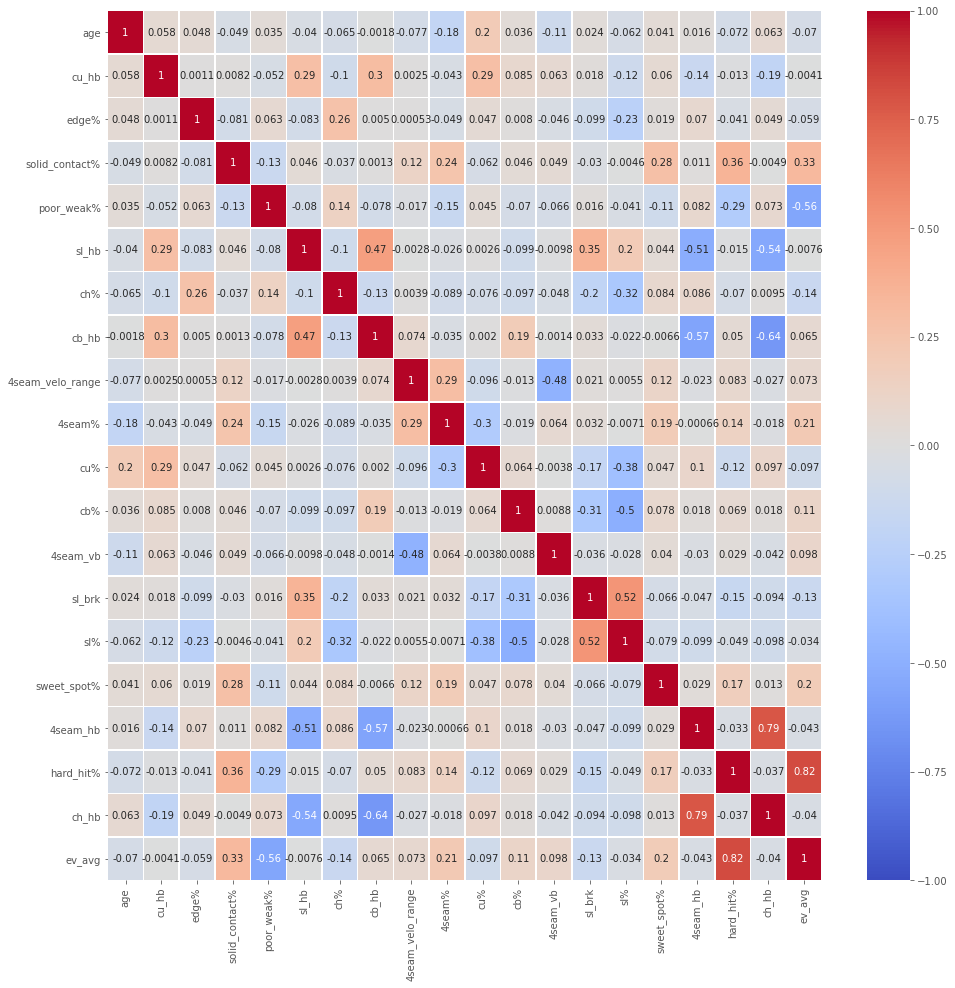

In [5]:
plt.figure(figsize = (16, 16))
sns.heatmap(X.corr(), annot = True, 
            vmin = -1, 
            vmax = 1,
            linewidths = 0.5,
            cmap = 'coolwarm');

# Modeling

### Standardize Data

In [6]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

### PCA

In [7]:
pca = PCA().fit(X)
principalComponents = pca.transform(X)

[3.03913577e-01 2.27709044e-01 1.36186977e-01 1.03467429e-01
 8.38022367e-02 2.75280497e-02 2.16425028e-02 1.78269394e-02
 1.55695386e-02 1.46773832e-02 1.18969365e-02 1.04321988e-02
 8.29353056e-03 6.60082973e-03 3.12804440e-03 2.92377030e-03
 2.20844004e-03 1.78158322e-03 3.56288070e-04 5.47007479e-05]


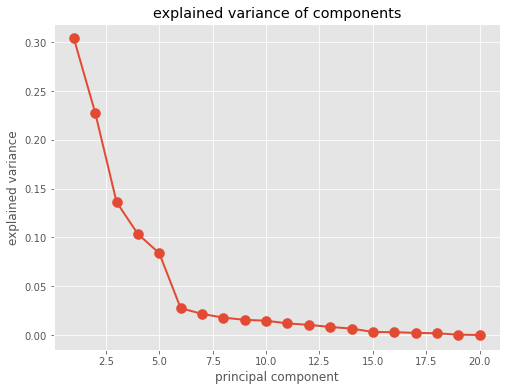

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,21), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 21), pca.explained_variance_ratio_, s = 100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');
print(pca.explained_variance_ratio_)

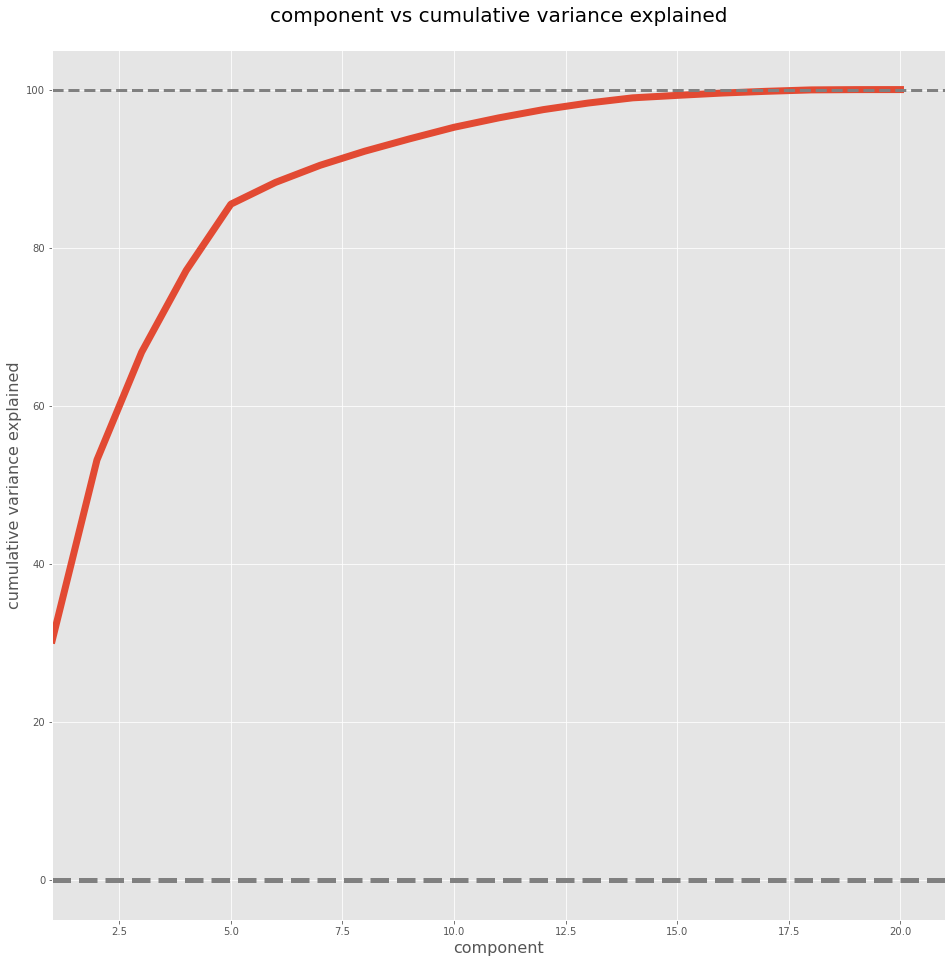

In [9]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(16,16))
component_number = range(1, 21)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,21], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [10]:
pca_component_1_eigenvec = pca.components_[0]

for weight, X in zip(pca_component_1_eigenvec, 
                     X.iloc[:,0:].columns):
    
    print(X, weight)

age 0.03775568088576538
cu_hb 0.010052163501661937
edge% 0.010947341011141115
solid_contact% -0.022728825858129638
poor_weak% 0.01613072511158109
sl_hb -0.009868994569588972
ch% 0.06898706590274897
cb_hb 0.006080362279077352
4seam_velo_range -0.00467797303175776
4seam% -0.8994838322577278
cu% 0.3616138958290732
cb% 0.07725778304152045
4seam_vb -0.013319703374871344
sl_brk -0.03793787144222347
sl% -0.19928891883805153
sweet_spot% -0.032038024368757995
4seam_hb 0.02432585096044331
hard_hit% -0.03916832609039168
ch_hb 0.04546143868824626
ev_avg -0.017463125954246317


In [11]:
pitch_df = pd.DataFrame(data = principalComponents, 
                        columns = ['PC1', 'PC2', 'PC3', 'PC4', 
                                   'PC5', 'PC6', 'PC7', 'PC8', 
                                   'PC9', 'PC10', 'PC11', 'PC12', 
                                   'PC13', 'PC14', 'PC15', 'PC16', 
                                   'PC17', 'PC18', 'PC19', 'PC20'])
# data = pca.transform(X_scaled)

#['age', 'cu_hb', 'edge%', 'solid_contact%', 'poor_weak%', 'sl_hb', 'ch%', 'cb_hb', '4seam_velo_range', 
# '4seam%', 'cu%', 'cb%', '4seam_vb', 'sl_brk', 'sl%', 'sweet_spot%', '4seam_hb', 'hard_hit%', 
# 'ch_hb', 'ev_avg']

pitch_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,34.314705,-16.930168,-19.261693,1.629832,15.383430,-4.863235,0.326065,2.648153,5.524368,-5.221181,-4.707487,6.311542,5.382853,-6.431292,1.566711,-1.110648,0.697554,-4.393478,0.131983,-0.102063
1,-5.282512,-3.354499,-11.015908,-10.414443,-3.184775,-9.297989,-2.378302,7.045870,-0.183430,0.101975,-1.875494,5.055871,6.569464,-5.962184,-0.789644,0.177779,-0.287810,1.289726,-0.502104,0.043071
2,-19.979665,29.583100,3.743245,9.124392,1.051393,-3.624681,9.094074,-2.578127,4.433561,1.945256,-3.752478,0.079696,5.705028,-8.632288,-1.323292,1.925420,-0.433177,0.117832,0.037347,0.022042
3,1.886339,-23.777282,-10.244130,7.026439,-10.754030,-3.787647,-7.053986,-0.607336,4.967870,-5.478740,-4.123124,1.014246,4.144304,-5.513067,-0.792410,1.384167,0.798116,2.403126,-0.142304,0.155982
4,49.553445,0.529680,6.761879,39.287972,-9.752738,-0.668927,-8.404135,-5.637378,-15.353962,-2.396859,0.200784,-0.137737,3.137305,-2.681278,-1.956203,5.871503,-0.065632,-4.672999,-0.493941,0.474635


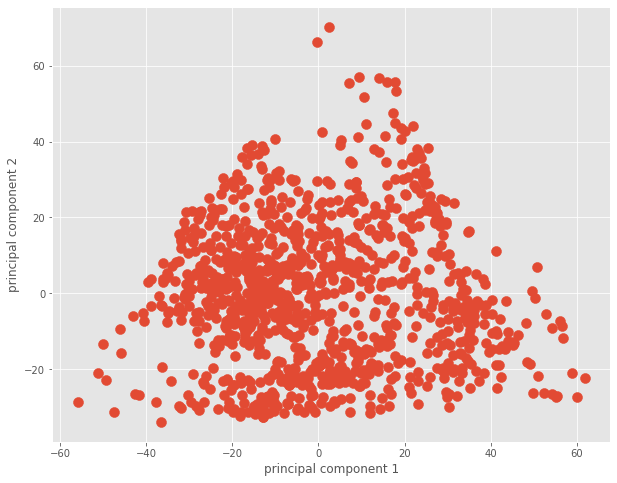

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pitch_df.iloc[:,0], pitch_df.iloc[:,1], s=100)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2');

In [13]:
# fig, ax = plt.subplots(4, 3, figsize=(10,8))

### K-Means

In [14]:
#ss = StandardScaler()
#X_scaled = ss.fit_transform()

In [15]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 21)
 
for k in K:
    km = KMeans(n_clusters=k).fit(pitch_df)
    km.fit(pitch_df)
 
    distortions.append(sum(np.min(cdist(pitch_df, km.cluster_centers_,
                                        'euclidean'), axis=1)) / pitch_df.shape[0])
    inertias.append(km.inertia_)
 
    mapping1[k] = sum(np.min(cdist(pitch_df, km.cluster_centers_,
                                   'euclidean'), axis=1)) / pitch_df.shape[0]
    mapping2[k] = km.inertia_

In [16]:
# distortion
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 37.32183945412662
2 : 33.12338480012873
3 : 30.80187438479206
4 : 28.976987095104764
5 : 27.566540551665177
6 : 26.807834008694087
7 : 26.00011163955671
8 : 25.28889367908579
9 : 24.59262295396365
10 : 24.06277833558818
11 : 23.56201173695579
12 : 23.10334434587695
13 : 22.864930845632635
14 : 22.461645964005395
15 : 22.18879801166988
16 : 21.92179426964274
17 : 21.735446095689706
18 : 21.43679062691377
19 : 21.21388283674776
20 : 20.97585227223289


In [17]:
# inertia
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 1631545.403432836
2 : 1279688.89594779
3 : 1101161.0163171263
4 : 991646.8734050576
5 : 898277.2814432652
6 : 840311.6560036979
7 : 789261.7699922837
8 : 747603.5478524171
9 : 710371.7013586615
10 : 678290.0683602113
11 : 648822.9351394122
12 : 625035.7650411621
13 : 610652.7533828707
14 : 588158.9954243676
15 : 571008.8679805237
16 : 559807.9284112134
17 : 549437.321220537
18 : 534704.6808222225
19 : 524308.294193072
20 : 509924.3730234072


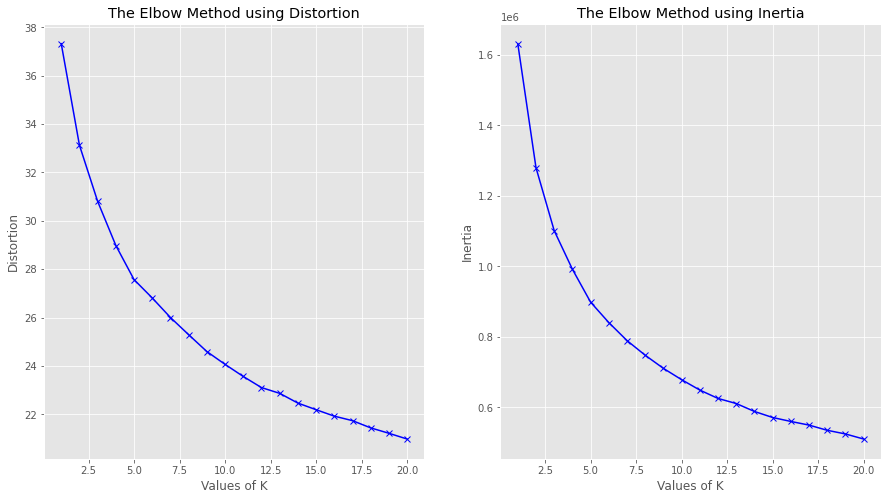

In [18]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

fig, ax = plt.subplots(1, 2, figsize = (15,8))
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[0].set_title('The Elbow Method using Distortion')

ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia')
ax[1].set_title('The Elbow Method using Inertia');

In [26]:
km = KMeans(n_clusters = 14,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[ 3  0 10 ...  4  2  0]


In [27]:
pitch_df['label'] = label
pitch_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,label
0,34.314705,-16.930168,-19.261693,1.629832,15.383430,-4.863235,0.326065,2.648153,5.524368,-5.221181,...,6.311542,5.382853,-6.431292,1.566711,-1.110648,0.697554,-4.393478,0.131983,-0.102063,3
1,-5.282512,-3.354499,-11.015908,-10.414443,-3.184775,-9.297989,-2.378302,7.045870,-0.183430,0.101975,...,5.055871,6.569464,-5.962184,-0.789644,0.177779,-0.287810,1.289726,-0.502104,0.043071,0
2,-19.979665,29.583100,3.743245,9.124392,1.051393,-3.624681,9.094074,-2.578127,4.433561,1.945256,...,0.079696,5.705028,-8.632288,-1.323292,1.925420,-0.433177,0.117832,0.037347,0.022042,10
3,1.886339,-23.777282,-10.244130,7.026439,-10.754030,-3.787647,-7.053986,-0.607336,4.967870,-5.478740,...,1.014246,4.144304,-5.513067,-0.792410,1.384167,0.798116,2.403126,-0.142304,0.155982,6
4,49.553445,0.529680,6.761879,39.287972,-9.752738,-0.668927,-8.404135,-5.637378,-15.353962,-2.396859,...,-0.137737,3.137305,-2.681278,-1.956203,5.871503,-0.065632,-4.672999,-0.493941,0.474635,1


In [28]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [ 3  0 10 ...  4  2  0]
Number of iterations: 36
Number of features: 21
Number of clusters: 14
Inertia: 598702.1150918333
Silhouette Score: 0.18071681531313963


In [29]:
centroids = km.cluster_centers_

print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')
print(centroids)

Predicted clusters to points:  [ 3  0 10  6  1  9  3  5 12  2] 

Location of centroids: 

[[-8.21871839e+00  4.42940268e+00 -1.04167123e+01 -9.93978073e-01
   1.15581487e+00 -2.43168288e+00 -5.54206281e-01  1.96723904e+00
  -1.16825918e+00 -2.13083576e-02  7.00294550e-01  6.58613779e-01
   3.03927998e-01  2.81435148e-01  1.29587938e-01  1.30348341e-01
   1.50549287e-01  2.12405675e-01  4.35772301e-03 -6.25164327e-02
   4.06134969e+00]
 [ 4.55866100e+01 -1.58272988e+01 -2.34475989e+00  3.74386039e+01
  -3.26858768e+00 -6.85086250e+00  1.05097019e+00 -3.51728217e+00
  -1.01201395e+00 -8.94266997e-01  8.43650007e-01 -9.86153109e-01
   5.96558461e-01  7.50211302e-01 -4.41802449e-02 -1.78715611e-01
   4.03586484e-02 -3.33269403e-02 -1.06284863e-01  9.97128570e-02
   1.00000000e+01]
 [ 1.88916093e+01  1.57300830e+01 -7.09811190e+00 -3.94597656e+00
  -1.49488196e+00  5.44884605e+00 -7.12739140e-01 -1.66391805e-01
  -4.52395149e-01  1.37480031e+00 -9.29154246e-02  9.47367170e-01
  -3.35391895e

In [30]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13
PC1,-8.218718,45.586610,18.891609,25.445428,-15.039362,-7.103922,3.992436,24.859974,-14.094488,30.194120,-15.631512,14.234350,-28.470754,-1.121003
PC2,4.429403,-15.827299,15.730083,-11.668896,1.604051,-23.360863,-18.168207,5.531954,-23.824435,-17.439391,23.925130,38.195515,-1.564574,-12.097300
PC3,-10.416712,-2.344760,-7.098112,-15.456696,23.536521,20.002884,-7.799372,18.951493,-9.207572,21.487175,2.499571,1.006327,-4.682780,-10.987569
PC4,-0.993978,37.438604,-3.945977,-6.826450,-1.459223,-8.980984,14.412454,-15.574299,-0.863179,6.094709,6.984792,2.407395,3.636925,-15.267011
PC5,1.155815,-3.268588,-1.494882,11.426791,2.886843,1.812794,-5.376686,0.155297,18.120867,-6.314680,2.396981,3.877179,-5.801773,-15.824534
PC6,-2.431683,-6.850863,5.448846,2.106343,-1.155701,-2.932890,2.703311,3.189888,0.292660,-1.089530,-2.797181,-0.940719,3.377707,-2.509330
PC7,-0.554206,1.050970,-0.712739,0.038544,0.179547,-1.347388,0.562787,1.468923,-0.831151,0.405995,0.718063,-0.934535,0.851326,-0.134703
PC8,1.967239,-3.517282,-0.166392,-0.097285,0.298694,-0.189254,-0.136463,1.717141,-1.114811,0.553438,-1.505779,-0.271351,-0.085695,-1.254250
PC9,-1.168259,-1.012014,-0.452395,2.651532,0.943612,-1.062594,0.583475,-3.266131,-0.610485,0.910791,1.292322,0.935512,-0.733368,1.459405
PC10,-0.021308,-0.894267,1.374800,-1.378193,-2.182298,3.327866,-1.301667,-2.447513,0.196309,1.872894,-0.352049,2.167658,1.111743,-2.019938


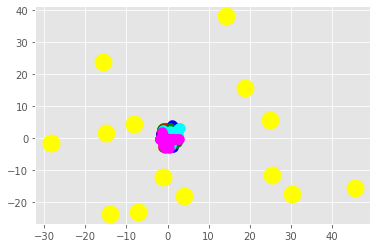

In [31]:
plt.scatter(X_scaled[label==0, 0], X_scaled[label==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[label==1, 0], X_scaled[label==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_scaled[label==2, 0], X_scaled[label==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X_scaled[label==3, 0], X_scaled[label==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X_scaled[label==4, 0], X_scaled[label==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', label = 'Centroids');